# Machine Learning - Assignment 2

## Decision tree induction algorithm for classification tasks

The aim of the assignment is to:

* Implement a decision tree induction algorithm for classification tasks.
* Make sure it works for real valued features and nominal features (categorical features without rank, e.g., red - blue - green).
* Test the algorithm on 3 datasets.

Follow the instructions and implement what is missing to complete the assignment. Some functions have been started to help you a little bit with the inputs or outputs of the function.

**Note:** You might need to go back and forth during your implementation of the code. The structure is set up to make implementation easier, but how you return values from the different functions might vary, and you might find yourself going back and change something to make it easier later on.

## Assignment preparations

We help you out with importing the libraries.

**IMPORTANT NOTE:** You may not import any more libraries than the ones already imported!

In [199]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Decision tree model

The main objective is to implement the decision tree model. The implemented decision tree needs to be recursive model, that is, it should be implemented general enough to call itself in order to grow. "Growing" a tree refers to the same thing as "training" a model.

As said in the introduction, the structure is set up to help with implementation, but the nature of this model makes it a bit harder to implement function-by-function. You will most likely go back and forth between these first tasks.

### 1) Grow Tree

We will start with the main function of the decision tree, the "growing" function. 

This function should be called when creating the model, but also from inside itself. It is responible for creating all the nodes and leafs in the tree.

In [200]:
def grow_tree(data, max_depth=None, min_samples_split=2, min_impurity_decrease=0.0, current_depth=0):
    if (stop1(data) or
        stop2(current_depth, max_depth) or
        stop3(len(data), min_samples_split) or
        stop4(data, min_impurity_decrease)):
        return create_leaf_node(data)

    best_feature, best_threshold = find_best_split(data)

    left_data, right_data = split_data(data, best_feature, best_threshold)

    # Recursivity
    left_subtree = grow_tree(left_data, max_depth, min_samples_split, min_impurity_decrease, current_depth + 1)
    right_subtree = grow_tree(right_data, max_depth, min_samples_split, min_impurity_decrease, current_depth + 1)

    return {'feature': best_feature, 'threshold': best_threshold, 'left': left_subtree, 'right': right_subtree}

def create_leaf_node(data):
    classes, counts = np.unique(data[:, -1], return_counts=True)
    return classes[np.argmax(counts)]

### 2) Growth stopping conditions (or stopping criterias)

The "grow_tree" function needs some way of stop growing, otherwise it will grow indefinitely. We will adress this issue here.

The trees stopping criterias needs to handle the following:

1) When a node has only datapoints of a single class.

2) Prevent the tree from growing to large, i.e., a max depth.

3) Prevent the tree nodes from becoming to small.

4) Prevent the tree from growing when the node is large (has a lot of datapoints) but it is very unbalanced. This is an extention to case 1.

Can you think of some other stopping criterias that is good to have? 

In [201]:
def calculate_impurity(data):
    classes, counts = np.unique(data[:, -1], return_counts=True)
    probabilities = counts / counts.sum()
    return -np.sum(probabilities * np.log2(probabilities + 1e-10))  # avoid log(0)

def stop1(data):
    classes = set(data[:, -1])
    return len(classes) == 1

def stop2(current_depth, max_depth):
    return max_depth is not None and current_depth >= max_depth

def stop3(num_samples, min_samples_split):
    return num_samples < min_samples_split

def stop4(data, min_impurity_decrease):
    impurity = calculate_impurity(data)
    return impurity < min_impurity_decrease

### 3) Best feature for splitting nodes

When we are growing the tree, we need to decide how we are going to split a node into two new nodes. This is achived by looking at the features of the data in the node and calculate the best feature to split on.

Here you have a choice:

* Split using **Information Entropy**
* Split using **Gini Impurity**

Finish the function below using Information Entropy or Gini Impurity.

**Note:** Your code should be able to handle both real and categorical features!

In [202]:
def calculate_entropy(data):
    classes, counts = np.unique(data[:, -1], return_counts=True)
    probabilities = counts / counts.sum()
    return -np.sum(probabilities * np.log2(probabilities + 1e-10))

def find_best_split(data):
    best_gain = -1
    best_feature = None
    best_threshold = None
    parent_entropy = calculate_entropy(data)

    for feature_idx in range(data.shape[1] - 1):
        feature_values = data[:, feature_idx]
        unique_values = np.unique(feature_values)

        for threshold in unique_values:
            left_data = data[feature_values < threshold]
            right_data = data[feature_values >= threshold]

            if len(left_data) == 0 or len(right_data) == 0:
                continue

            left_entropy = calculate_entropy(left_data)
            right_entropy = calculate_entropy(right_data)

            n_left = len(left_data)
            n_right = len(right_data)
            n_total = n_left + n_right
            child_entropy = (n_left / n_total) * left_entropy + (n_right / n_total) * right_entropy

            gain = parent_entropy - child_entropy

            if gain > best_gain:
                best_gain = gain
                best_feature = feature_idx
                best_threshold = threshold

    return best_feature, best_threshold

### 4) Split data

When growing the tree, we need to split the data multiple times, and what we decide to split varies a lot. It is similar to splitting data into train and test sets (remember from assignment 1), but we split the data based on the best feature for growing a good tree.

**IMPORTANT NOTE:** To calculate binary splits for real-valued features, the following rule must be applied: an instance with a feature value lower than the mean feature value follows the left edge from the split node while all other instances follow the right edge from the split node.

In [203]:
def is_categorical(feature_idx, data):
    feature_values = data[:, feature_idx]
    return not np.issubdtype(feature_values.dtype, np.number)

def split_data(data, feature_idx, threshold=None):
    if is_categorical(feature_idx, data):
        # categorical features, split on equality
        left_data = data[data[:, feature_idx] == threshold]
        right_data = data[data[:, feature_idx] != threshold]
    else:
        # numerical features, split on the mean value
        feature_values = data[:, feature_idx]
        mean_value = np.mean(feature_values)
        left_data = data[feature_values < mean_value]
        right_data = data[feature_values >= mean_value]

    return left_data, right_data

### 5) Predict with tree model

Finally, when we have grown our tree, we would like to use it for prediction. When using the tree for prediction, we traverse the tree for each datapoint untill we land in a leaf node.

In [204]:
def predict_with_tree(tree, data_point):
    if isinstance(tree, dict):
        feature_idx = tree['feature']
        threshold = tree['threshold']

        if is_categorical(feature_idx, np.zeros((1, data_point.shape[0] + 1))):  # Dummy
            if data_point[feature_idx] == threshold:
                return predict_with_tree(tree['left'], data_point)
            else:
                return predict_with_tree(tree['right'], data_point)
        else:
            if data_point[feature_idx] < threshold:
                return predict_with_tree(tree['left'], data_point)
            else:
                return predict_with_tree(tree['right'], data_point)
    else:  # Leaf node
        return tree  # Return the predicted class

## Test decision tree model, compare with scikit learn, and plot dataset results

In the last part of the lab, you are going to test your tree code and compare it to scikit learn. The goal is not to be better than an established library, but to give you an indication about if you are on the right track.

You will need to plot the results from your model and the scikit learn model using matplotlib. We suggest a simple but informative bar-charts.

To make the comparison fair, you should train and test both your decision tree algorithm and the scikit learn at least 5 times, and shuffle the data each time before splitting the data into a train and test set.

The datasets are:

* Wine - (https://archive.ics.uci.edu/dataset/109/wine)
* Heart disease - (https://archive.ics.uci.edu/dataset/45/heart+disease)
* Car - (https://archive.ics.uci.edu/dataset/19/car+evaluation)

**IMPORTANT NOTE 1:** Take note of the feature types in the datasets, some features are numerical in value but are in fact categorical features. Be sure to handle these features correctly!

**IMPORTANT NOTE 2:** In this assignment it helps to add an additional header with information about the features and if they are nominal (n) or real (r) features.

In [205]:
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

You may use the "**accuracy_score**" function from scikit learn (imported above) to compare the performance of your own and scikit learns models.

See below for an example use.

In [206]:
y_true = [1,1,1,1,1] # Pretend labels
y_pred = [1,1,2,2,1] # Pretend prediction

accuracy_score(y_true, y_pred)

0.6

### 6) Dataset 1: Wine

In [207]:
def compare_decision_tree_models(data, max_depth=5):

    X = data[:, :-1]
    y = data[:, -1]

    our_model_accuracies = []
    sklearn_model_accuracies = []

    for _ in range(5):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

        train_data = np.column_stack((X_train, y_train))

        our_tree = grow_tree(train_data, max_depth=max_depth)
        y_pred_our = [predict_with_tree(our_tree, x) for x in X_test]
        our_accuracy = accuracy_score(y_test, y_pred_our)
        our_model_accuracies.append(our_accuracy)

        sklearn_tree = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
        sklearn_tree.fit(X_train, y_train)
        y_pred_sklearn = sklearn_tree.predict(X_test)
        sklearn_accuracy = accuracy_score(y_test, y_pred_sklearn)
        sklearn_model_accuracies.append(sklearn_accuracy)

    our_mean_accuracy = np.mean(our_model_accuracies)
    sklearn_mean_accuracy = np.mean(sklearn_model_accuracies)

    plt.figure(figsize=(12, 7))
    ax = plt.gca()

    our_color = "#006EBC"
    sklearn_color = "#d23030"

    bar_width = 0.35
    plt.bar(np.arange(5) - bar_width/2, our_model_accuracies, width=bar_width, label=f"Our Model ({our_mean_accuracy:.2f})", color=our_color, edgecolor='black', linewidth=0.5)
    plt.bar(np.arange(5) + bar_width/2, sklearn_model_accuracies, width=bar_width, label=f"Scikit-learn ({sklearn_mean_accuracy:.2f})", color=sklearn_color, edgecolor='black', linewidth=0.5)

    plt.axhline(y=our_mean_accuracy, color=our_color, linestyle='-', alpha=0.7, linewidth=1.5)
    plt.axhline(y=sklearn_mean_accuracy, color=sklearn_color, linestyle='-', alpha=0.7, linewidth=1.5)

    plt.xticks(np.arange(5), [f"Run {i+1}" for i in range(5)], fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylabel("Accuracy", fontsize=14, labelpad=10)
    plt.title("Decision Tree Model Comparison", fontsize=16, pad=20)
    plt.legend(fontsize=12, framealpha=1)

    ax.yaxis.grid(True, linestyle='--', alpha=0.6)
    ax.set_axisbelow(True)

    for i, (our_acc, sk_acc) in enumerate(zip(our_model_accuracies, sklearn_model_accuracies)):
        plt.text(i - bar_width/2, our_acc + 0.01, f"{our_acc:.2f}", ha='center', fontsize=10, fontweight='bold')
        plt.text(i + bar_width/2, sk_acc + 0.01, f"{sk_acc:.2f}", ha='center', fontsize=10, fontweight='bold')

    plt.tight_layout()
    plt.subplots_adjust(top=0.9, bottom=0.15)
    plt.show()

    return our_model_accuracies, sklearn_model_accuracies, our_mean_accuracy, sklearn_mean_accuracy

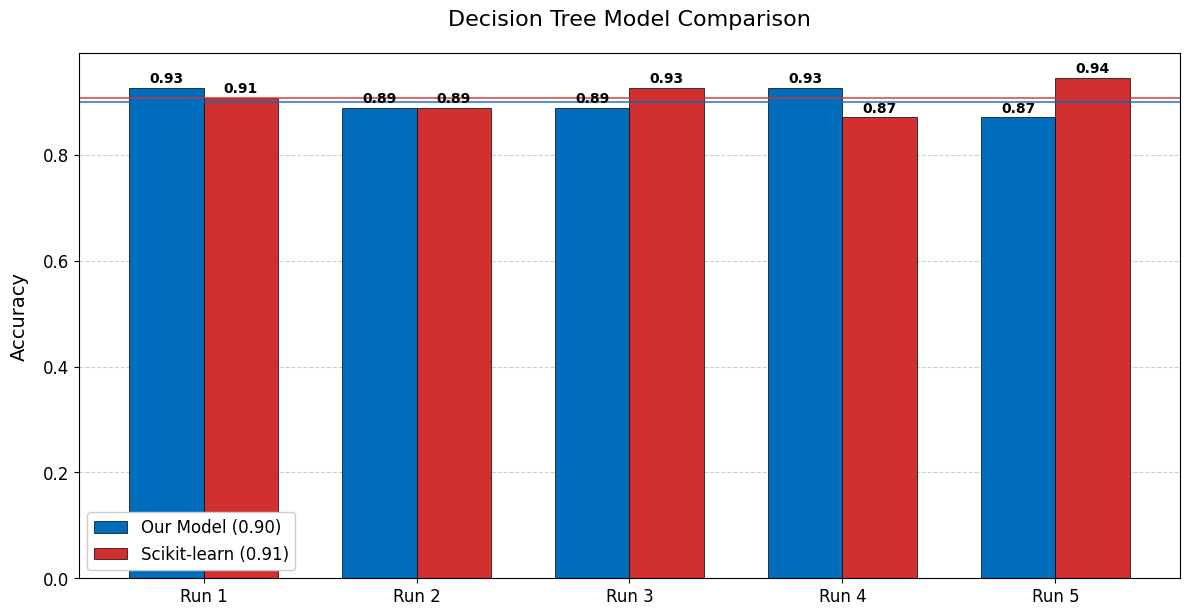

([0.9259259259259259,
  0.8888888888888888,
  0.8888888888888888,
  0.9259259259259259,
  0.8703703703703703],
 [0.9074074074074074,
  0.8888888888888888,
  0.9259259259259259,
  0.8703703703703703,
  0.9444444444444444],
 np.float64(0.9),
 np.float64(0.9074074074074074))

In [208]:
data_wine = pd.read_csv("wine.csv", skiprows=[1]).to_numpy()

compare_decision_tree_models(data_wine, max_depth=5)

### 7) Dataset 2: Heart Disease

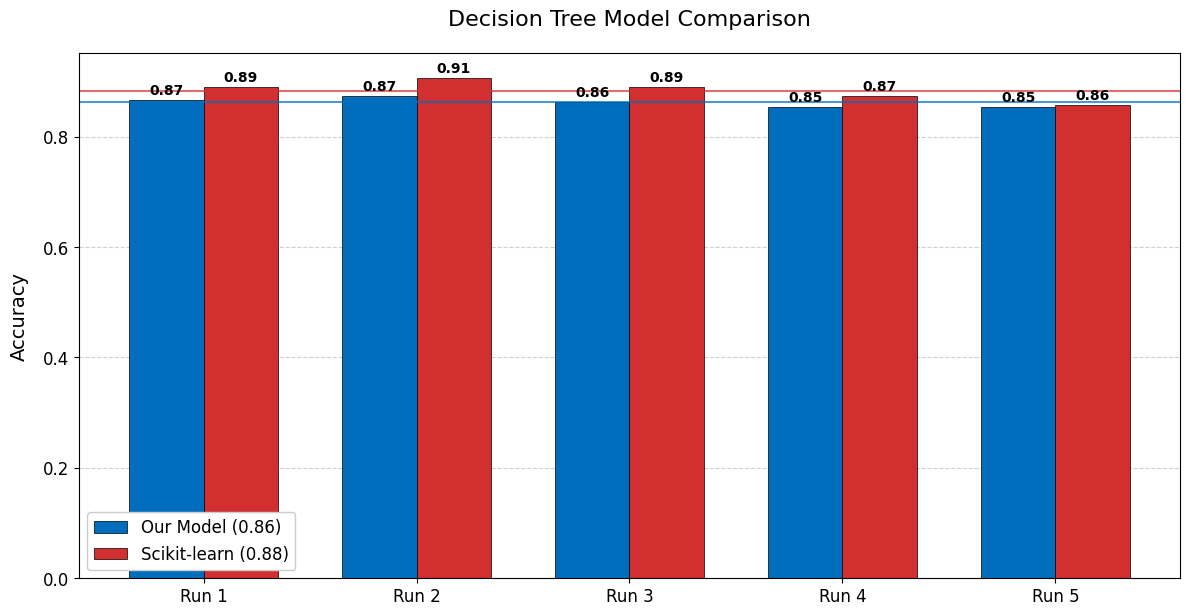

([0.8668831168831169,
  0.8733766233766234,
  0.8636363636363636,
  0.8538961038961039,
  0.8538961038961039],
 [0.8896103896103896,
  0.9058441558441559,
  0.8896103896103896,
  0.8733766233766234,
  0.8571428571428571],
 np.float64(0.8623376623376624),
 np.float64(0.883116883116883))

In [209]:
data_heart = pd.read_csv("heart.csv").to_numpy()

compare_decision_tree_models(data_heart, max_depth=5)

### 8) Dataset 3: Car

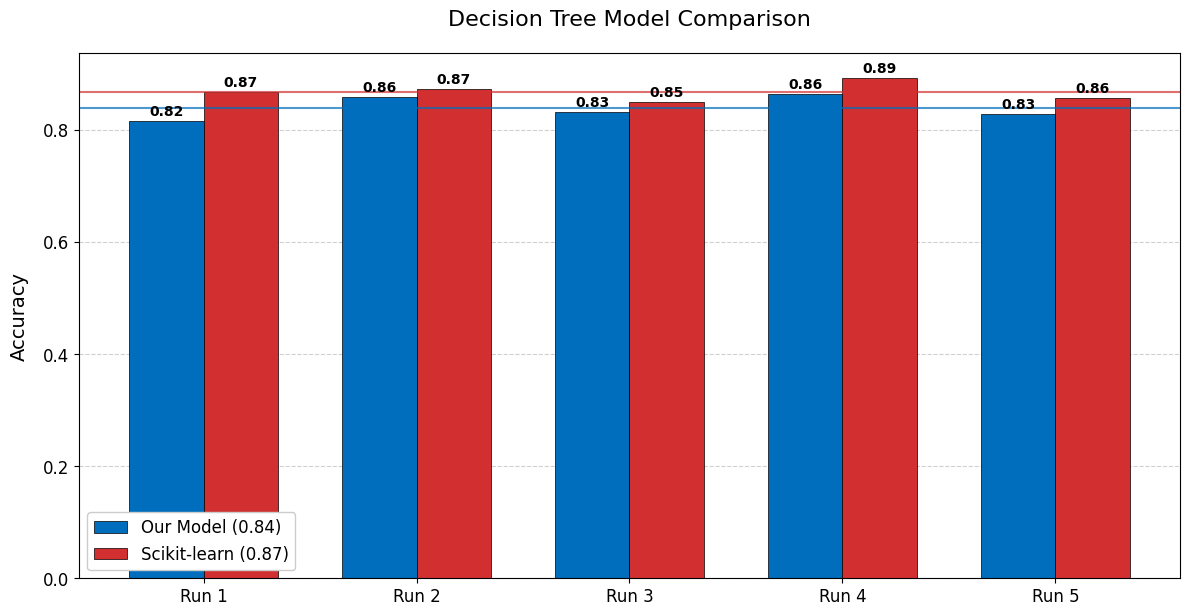

([0.815028901734104,
  0.859344894026975,
  0.8323699421965318,
  0.8631984585741811,
  0.8285163776493256],
 [0.8670520231213873,
  0.8728323699421965,
  0.8497109826589595,
  0.8921001926782274,
  0.8574181117533719],
 np.float64(0.8396917148362235),
 np.float64(0.8678227360308284))

In [210]:
data_car = pd.read_csv("car.csv")

for col in data_car.columns:
    unique_values = data_car[col].unique()
    value_to_numeric = {value: idx for idx, value in enumerate(unique_values)}
    data_car[col] = data_car[col].map(value_to_numeric)

data_car = data_car.to_numpy()

compare_decision_tree_models(data_car, max_depth=5)

### 9) Training with normalized data on the wine-dataset

So far, we have trained our decision trees with "raw" data, i.e., we haven't done much preprocessing on the data.

Here we will do minor preprocessing on the data with the help of the scikit-learn library: https://scikit-learn.org/stable/modules/preprocessing.html

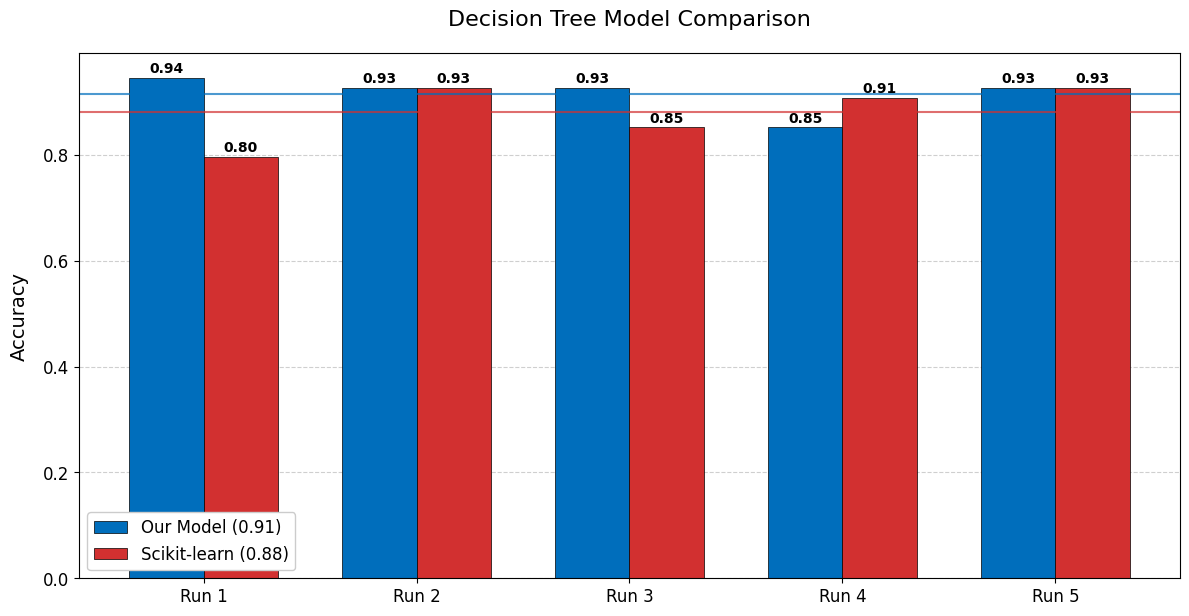

([0.9444444444444444,
  0.9259259259259259,
  0.9259259259259259,
  0.8518518518518519,
  0.9259259259259259],
 [0.7962962962962963,
  0.9259259259259259,
  0.8518518518518519,
  0.9074074074074074,
  0.9259259259259259],
 np.float64(0.9148148148148147),
 np.float64(0.8814814814814815))

In [211]:
from sklearn import preprocessing

data_wine = pd.read_csv("wine.csv", skiprows=[1]).to_numpy()
X_wine = data_wine[:, :-1]
y_wine = data_wine[:, -1]

x_scaler = preprocessing.MinMaxScaler()
X_wine_scaled = x_scaler.fit_transform(X_wine)
data_wine[:, :-1] = X_wine_scaled

compare_decision_tree_models(data_wine, max_depth=5)

# Questions for examination:

In addition to completing the assignment with all its tasks, you should also prepare to answer the following questions:

1) Why is growing the tree indefinitely such a bad idea? The performance would increase would it not?

2) Beside preventing the tree from growing to large, what is the purpose of 'stopping criterias'?

3) What is the difference between **Information Entropy** and **Gini Impurity**?

4) What are some pros about using decision trees?

5) Did preprocessing the data help with performance when using decision trees?

# Finished!

Was part of the setup incorrect? Did you spot any inconsistencies in the assignment? Could something improve?

If so, please write them and send via email and send it to:

* marcus.gullstrand@ju.se

Thank you!